<a href="https://colab.research.google.com/github/YuliaLoburets/ML_learning/blob/main/HW_2_4_kNN_%D0%9A%D1%80%D0%BE%D1%81%D0%B2%D0%B0%D0%BB%D1%96%D0%B4%D0%B0%D1%86%D1%96%D1%8F_%D1%96_%D1%82%D1%8E%D0%BD%D0%B8%D0%BD%D0%B3_%D0%B3%D1%96%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%96%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, f1_score, accuracy_score)

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/ML')
from process_bank_churn import preprocess_data

In [ ]:
raw_df = pd.read_csv('drive/MyDrive/ML/train.csv')
raw_df.drop(columns=['Surname','id','CustomerId'], inplace=True)

In [ ]:
raw_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [ ]:
X_train, train_targets, X_val, val_targets, input_cols, scaler, encoder = preprocess_data(raw_df, 'Exited')

In [ ]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1.0,0.0,0.0,0.0,1.0
1,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,1.0,0.0,0.0,1.0,0.0
2,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,0.0,1.0,0.0,0.0,1.0
3,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,0.0,1.0,0.0,1.0
4,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1.0,0.0,0.0,0.0,1.0


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [ ]:
train_proba = knn.predict_proba(X_train)[:,1]
val_proba = knn.predict_proba(X_val)[:,1]

In [ ]:
def plot_roc_auc(prediction,targets, df):
  fpr, tpr, thresholds = roc_curve(targets,  prediction)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {df} data')
  plt.legend(loc="lower right")
  plt.show()
  accuracy = accuracy_score(targets, (prediction > 0.5).astype(int))
  print(f'Accuracy score for {df} data: {accuracy}')

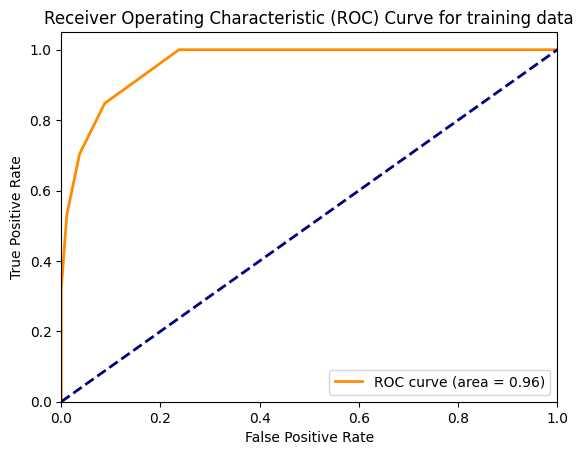

Accuracy score for training data: 0.9103333333333333


In [ ]:
plot_roc_auc(prediction = train_proba, targets=train_targets, df='training')

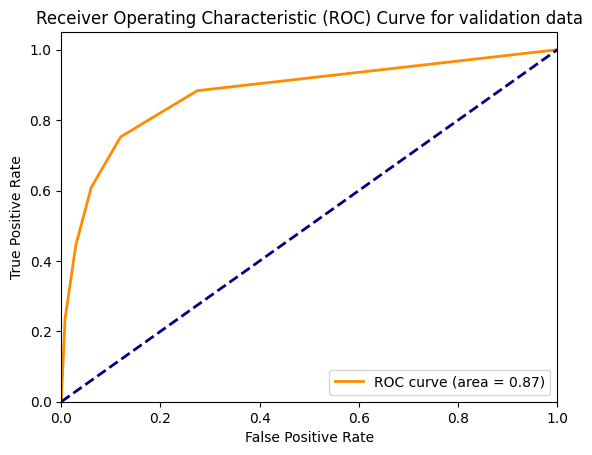

Accuracy score for validation data: 0.8723333333333333


In [ ]:
plot_roc_auc(prediction = val_proba, targets=val_targets, df='validation')

В цілому значення AUROC є високим і тренувальних та валідаціних даних, але схоже, що модель є перенавченою, так як значення AUROC впало на валідаціних даних.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [ ]:
knn_best = knn_gs.best_estimator_

print(knn_gs.best_params_, knn_gs.best_score_)

{'n_neighbors': 11} 0.8860833333333333


In [ ]:
knn_2 = KNeighborsClassifier(n_neighbors=11)

In [ ]:
knn_2.fit(X_train, train_targets)

KNeighborsClassifier(n_neighbors=11)

In [ ]:
train_proba_2 = knn_2.predict_proba(X_train)[:,1]
val_proba_2 = knn_2.predict_proba(X_val)[:,1]

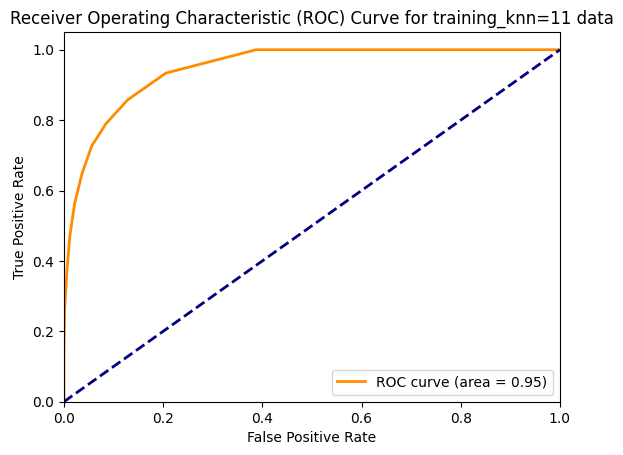

Accuracy score for training_knn=11 data: 0.8993333333333333


In [ ]:
plot_roc_auc(prediction = train_proba_2, targets=train_targets, df='training_knn=11')

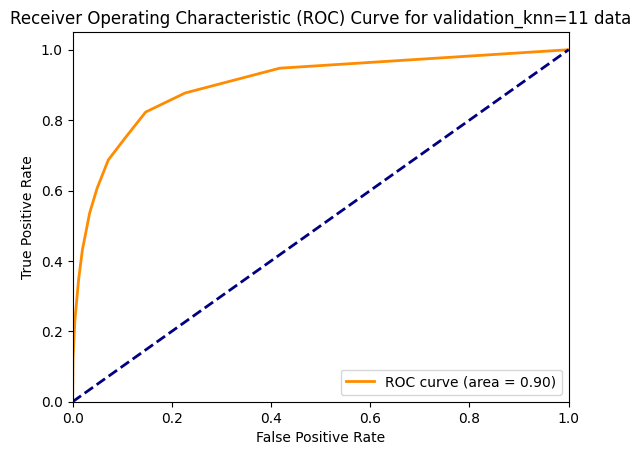

Accuracy score for validation_knn=11 data: 0.8806666666666667


In [ ]:
plot_roc_auc(prediction = val_proba_2, targets=val_targets, df='validation_knn=11')

Модель стала кращою у порівнянні з попереднім завданням, тому що значення AUROC стало стабільнішим і не досить суттєва різниця від значення на тренувальних даних.

In [ ]:
test_df = pd.read_csv('drive/MyDrive/ML/test.csv')
test_df.drop(columns=['Surname','id','CustomerId'], inplace=True)

In [ ]:
from process_bank_churn import preprocess_new_data

In [ ]:
X_test = preprocess_new_data(test_df,input_cols, scaler,encoder)
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-1.034678,-0.944682,-1.087792,1.720173,-1.108193,0.515062,1.016977,0.875226,0.0,1.0,0.0,0.0,1.0
1,-1.490909,0.161227,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.109098,1.0,0.0,0.0,0.0,1.0
2,0.651991,0.652742,1.069040,-0.717950,0.769304,0.515062,-0.983306,0.850584,1.0,0.0,0.0,0.0,1.0
3,0.804068,0.898500,-0.728320,-0.717950,-1.108193,0.515062,1.016977,1.073044,0.0,0.0,1.0,0.0,1.0
4,-0.924077,0.652742,1.069040,-0.717950,0.769304,0.515062,1.016977,0.563521,0.0,0.0,1.0,0.0,1.0


In [ ]:
submission_file = pd.read_csv('drive/MyDrive/ML/sample_submission.csv')
test_df['Exited'] = knn_2.predict_proba(X_test)[:,1]
submission_file['Exited'] = test_df['Exited']
submission_file.head()

,id,Exited
0,15000,0.090909
1,15001,0.000000
2,15002,0.000000
3,15003,0.363636
4,15004,0.090909


In [ ]:
file_path = '/content/drive/MyDrive/ML/submission_knn_grid.csv'
submission_file.to_csv(file_path, index=False)

Але дана модель не є суттєво кращою за модель дерева рішень - значення AUROC не збільшилось

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import time

In [ ]:
clf  = DecisionTreeClassifier(random_state=42)

In [ ]:
param_grid ={'max_depth': np.arange(1,20,2),
             'max_leaf_nodes': np.arange(2,10,1)}
clf_grid = GridSearchCV(clf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
start_time = time.time()
clf_grid.fit(X_train, train_targets)
end_time = time.time()


In [ ]:
print("Найкращі параметри:", clf_grid.best_params_)
print("Час виконання пошуку: {:.2f} секунд".format(end_time - start_time))

Найкращі параметри: {'max_depth': 5, 'max_leaf_nodes': 9}
Час виконання пошуку: 4.03 секунд


In [ ]:
dt_best = DecisionTreeClassifier(random_state=42, max_depth=9, criterion='gini', max_leaf_nodes=9)

In [ ]:
dt_best.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=9, max_leaf_nodes=9, random_state=42)

In [ ]:
train_proba_3 = dt_best.predict_proba(X_train)[:,1]
val_proba_3 = dt_best.predict_proba(X_val)[:,1]

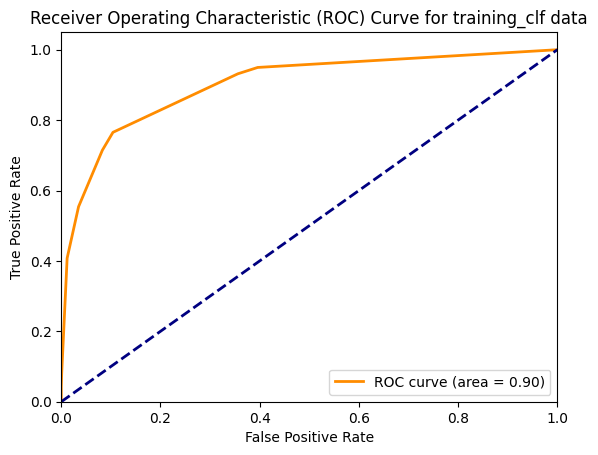

Accuracy score for training_clf data: 0.8815


In [ ]:
plot_roc_auc(prediction = train_proba_3, targets=train_targets, df='training_clf')

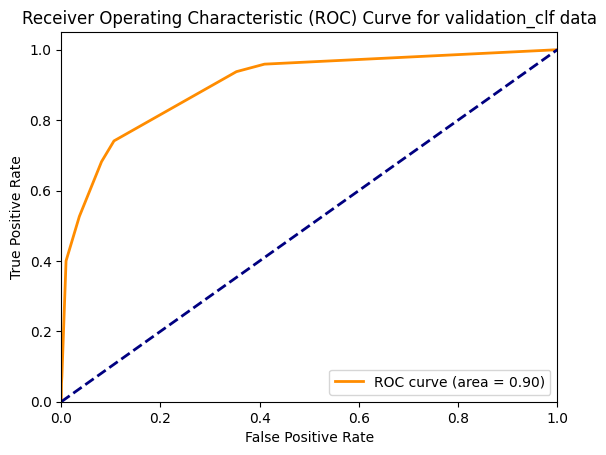

Accuracy score for validation_clf data: 0.8746666666666667


In [ ]:
plot_roc_auc(prediction = val_proba_3, targets=val_targets, df='validation_clf')

Значення AUROC не сильно відрізняється на тренувальних та валідаційних даних - в цілому модель непогана. Вона є кращою за ту модель, яку вручну відбирала в минулому ДЗ: там було значення AUROC 0.85 на валідаціних даних.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [ ]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
model = DecisionTreeClassifier(random_state=42)

In [ ]:
clf_random = RandomizedSearchCV(
    model,
    params_dt,
    n_iter = 40,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    refit=True,
    random_state=42,
    n_jobs=-1
)

In [ ]:
start_time = time.time()
clf_random.fit(X_train, train_targets)
end_time = time.time()


print("Best parameters found:", clf_random.best_params_)
print(f"Time taken: {end_time - start_time:.2f} seconds")

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters found: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}
Time taken: 0.85 seconds


In [ ]:
dt_random_search_best = DecisionTreeClassifier(random_state=42, splitter='best', min_samples_split=20, min_samples_leaf= 2, max_leaf_nodes= 14, max_features=None, max_depth=16, criterion= 'entropy' )

In [ ]:
dt_random_search_best.fit(X_train, train_targets)

DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=42)

In [ ]:
train_proba_4 = dt_random_search_best.predict_proba(X_train)[:,1]
val_proba_4 = dt_random_search_best.predict_proba(X_val)[:,1]

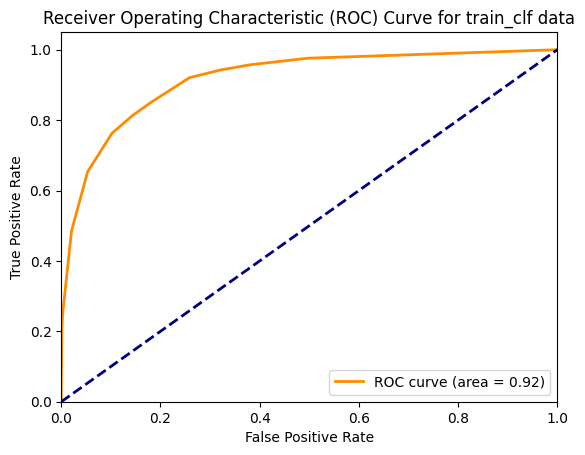

Accuracy score for train_clf data: 0.8871666666666667


In [ ]:
plot_roc_auc(prediction = train_proba_4, targets=train_targets, df='train_clf')

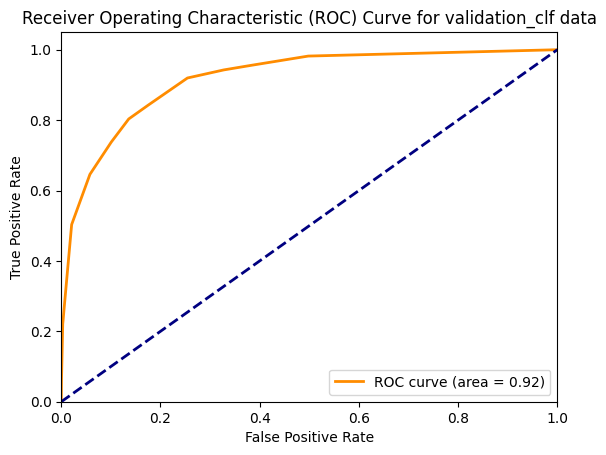

Accuracy score for validation_clf data: 0.882


In [ ]:
plot_roc_auc(prediction = val_proba_4, targets=val_targets, df='validation_clf')

Дана модель є трохи кращою , ніж попередня, так як значення AUROC є вищим на тренувальних та валідаційних даних.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [ ]:
test_df['Exited'] = dt_random_search_best.predict_proba(X_test)[:,1]
submission_file['Exited'] = test_df['Exited']
submission_file.head()

,id,Exited
0,15000,0.237911
1,15001,0.012115
2,15002,0.203947
3,15003,0.569848
4,15004,0.082171


In [ ]:
file_path = '/content/drive/MyDrive/ML/submission_clf_random.csv'
submission_file.to_csv(file_path, index=False)

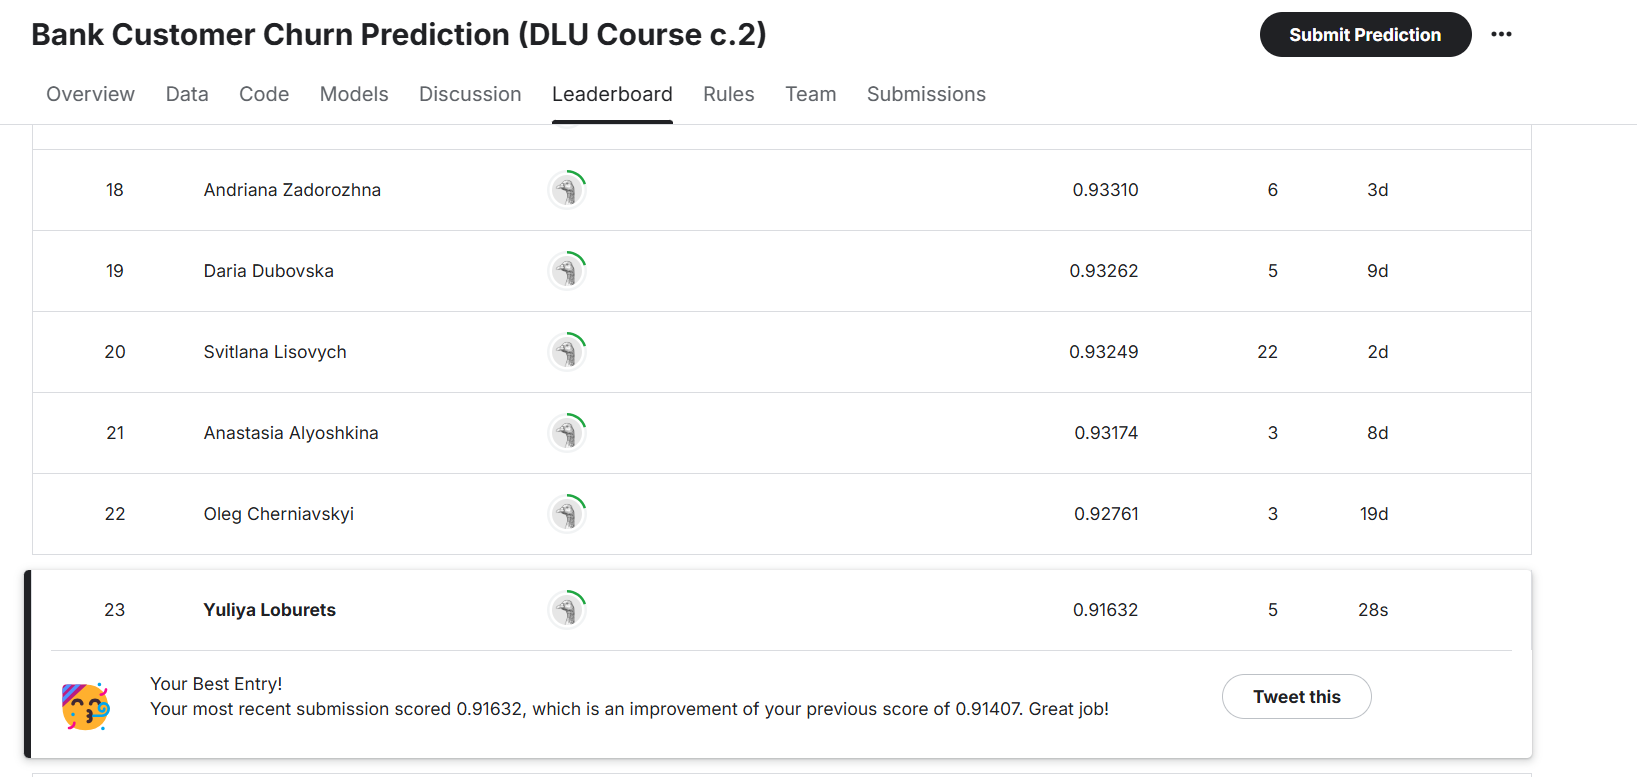

In [49]:
from IPython.display import Image, display
img_path = "/content/drive/My Drive/ML/Screenshot.png"
display(Image(img_path))